<a href="https://colab.research.google.com/github/vivek0464/Credit-Card-Fraud-Detection-and-Robot-Localization/blob/main/Robot_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import enum

In [ ]:
def Normalize(column):
    total = 0
    for i in range(column.shape[0]):
        total = total+column[i][0]
    for i in range(column.shape[0]):
        column[i][0] = column[i][0]/total

def XorDistance(D1, D2):
    (i1, i2, i3, i4) = D1
    (j1, j2, j3, j4) = D2
    dist = abs(i1-j1)+abs(i2-j2)+abs(i3-j3)+abs(i4-j4)
    return dist

def ManhattanDistance(D1, D2):
    (i1, j1) = D1
    (i2, j2) = D2
    dist = abs(i1-i2)+abs(j1-j2)
    return dist

def grid_visualize(C):
    temp = [[0 for i in range(16)] for j in range(4)]
    for i in range(C.shape[0]):
        (y, x) = pos[i]
        temp[y][x] = C[i][0]
    temp = np.array(temp)
    print(temp) 

def InitializeGrid():
    grid = [[0 for i in range(16)] for j in range(4)]
    grid[0][4] = grid[0][10] = grid[0][14] = 1
    grid[1][0] = grid[1][1] = grid[1][4] = grid[1][6] = grid[1][7] = grid[1][9] = grid[1][11] = grid[1][13] = grid[1][14] = grid[1][15] = 1
    grid[2][0] = grid[2][4] = grid[2][6] = grid[2][7] = grid[2][13] = grid[2][14] = 1
    grid[3][2] = grid[3][6] = grid[3][11] = 1
    return grid

def ShowGrid():
    mat = [[j for j in i] for i in grid]
    for i in range(4):
        for j in range(16):
            if grid[i][j] == 0:
                mat[i][j] = id[(i, j)]
            else:
                mat[i][j] = -1
    print(np.array(mat))

def generate_path(l):
    current = random.randint(0, 41)
    path = list()
    for i in range(l):
        path.append(current)
        if neighbours_count[current] == 0:
            continue
        r = random.randint(1, neighbours_count[current])
        for j in range(4):
            if neighbours[current][j] == 0:
                r = r-1
                if r == 0:
                    (y, x) = location[current]
                    if j == 0:
                        current = index_map[(y-1, x)]
                    elif j == 1:
                        current = index_map[(y+1, x)]
                    elif j == 2:
                        current = index_map[(y, x-1)]
                    else:
                        current = index_map[(y, x+1)]
                    break
    return path

def generate_evidence(path, e):
    evidence = list()
    for i in range(len(path)):
        a, b, c, d = neighbours[path[i]]
        p = random.uniform(0, 1)
        if p < e:
            a = 1-a
        p = random.uniform(0, 1)
        if p < e:
            b = 1-b
        p = random.uniform(0, 1)
        if p < e:
            c = 1-c
        p = random.uniform(0, 1)
        if p < e:
            d = 1-d
        evidence.append((a, b, c, d))
    return evidence



def Initialize(err):
    temp_O = [[[0 for i in range(S)] for j in range(S)] for k in range(16)]
    for i in range(16):
        for j in range(S):
            d = XorDistance(neighbours_type[i], neighbours[j])
            temp_O[i][j][j] = ((1-err)**(4-d))*(err**d)
    temp_O = np.array(temp_O)
    return temp_O

In [ ]:
grid = InitializeGrid()
location = {}
index_map = {}
neighbours_type = {}
neighbours = {}
S = 0

for i in range(4):
    for j in range(16):
        if grid[i][j] == 0:
            location[S] = (i, j)
            index_map[(i, j)] = S
            S = S+1

neighbours_count = [0 for i in range(S)]
TransitionMatrix = [[0 for i in range(S)] for j in range(S)]

for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                neighbours_type[8*i+4*j+2*k+l] = (i, j, k, l)
                index_map[(i, j, k, l)] = 8*i+4*j+2*k+l

for i in range(S):
    N_ = 1
    S_ = 1
    E_ = 1
    W_ = 1
    (y, x) = location[i]
    if (y-1, x) in index_map.keys():
        N_ = 0
    if (y+1, x) in index_map.keys():
        S_ = 0
    if (y, x-1) in index_map.keys():
        E_ = 0
    if (y, x+1) in index_map.keys():
        W_ = 0
    neighbours[i] = (N_, S_, E_, W_)
    neighbours_count[i] = XorDistance(neighbours[i], (1, 1, 1, 1))
    if neighbours_count[i] == 0:
        TransitionMatrix[i][i] = 1
        continue
    for j in range(S):
        if ManhattanDistance(location[i], location[j]) == 1:
            TransitionMatrix[i][j] = 1 / neighbours_count[i]
TransitionMatrix = np.array(TransitionMatrix)

In [ ]:
def MostLikelyLocation(evidence, err = 0.1):
    # Assign starting values
    f0 = [1/S for i in range(S)]
    f0 = np.array(f0)[np.newaxis]
    # print(S)
    f0 = f0.T
    f = f0
    # print(f)
    O = Initialize(err)
    for i in range(len(evidence)):
        # As per recursive definition
        f = O[index_map[evidence[i]]].dot((TransitionMatrix.T).dot(f))
        # Normalize the probabilities 
        Normalize(f)
    # print(f)
    # Choose state with maximum probability
    maximum_probability_state = 0
    for i in range(1, S):
        if f[i][0] > f[maximum_probability_state][0]:
            maximum_probability_state = i
    return maximum_probability_state

# Using the Viterbi Algorithm
def MostLikelyPath(evidence, err = 0.1):    
    m0 = [[0 for i in range(S)] for j in range(S)]
    for i in range(S):
        m0[i][i] = 1/S
    path = [[] for i in range(S)]
    m0 = np.array(m0)
    m = m0
    O = Initialize(err)
    for i in range(len(evidence)):
        m = O[index_map[evidence[i]]].dot((TransitionMatrix.T).dot(m))
        temp = list()
        for j in range(S):
            mx = 0
            for k in range(1, S):
                if m[j][k] > m[j][mx]:
                    mx = k
            l = [t for t in path[mx]]
            l.append(j)
            temp.append(l)
            m[j][j] = m[j][mx]
            for k in range(S):
                if k != j:
                    m[j][k] = 0
        path = [[j for j in l] for l in temp]
        sum = 0
        for j in range(S):
            sum = sum+m[j][j]
        for j in range(S):
            m[j][j] = m[j][j]/sum
    mx = 0
    for i in range(1, S):
        if m[i][i] > m[mx][mx]:
            mx = i
    return path[mx]

In [ ]:
evidence = [(1,1,1,0), (1,1,0,0), (1,0,0,0), (1,0,0,1), (0,0,0,1), (0,0,0,1)]
print(MostLikelyLocation(evidence))
MostLikelyPath(evidence)

21


[0, 1, 2, 3, 14, 21]

In [ ]:
E = [0.0, 0.02, 0.05, 0.1, 0.2]

localization_error = list()
for k in range(5):
    temp = list()
    O = Initialize(E[k])
    for i in range(4):
        sum = 0
        for j in range(40):
            path = generate_path(i+1)
            evidence = generate_evidence(path, E[k])
            result = MostLikelyLocation(evidence, E[k])
            sum = sum + ManhattanDistance(location[result], location[path[i]])
        sum = sum/40
        temp.append(sum)
    localization_error.append(temp)

path_accuracy = list()
for k in range(5):
    temp = list()
    O = Initialize(E[k])
    for i in range(4):
        sum = 0
        for j in range(40):
            path = generate_path(i+1)
            evidence = generate_evidence(path, E[k])
            result = MostLikelyPath(evidence, err = E[k])
            for l in range(i+1):
                if path[l] == result[l]:
                    sum = sum+1
        sum = sum/((i+1)*40)
        temp.append(sum)
    path_accuracy.append(temp)

In [ ]:
print(localization_error)
print(path_accuracy)

[[5.175, 1.225, 1.6, 0.45], [4.5, 1.975, 1.425, 0.4], [5.05, 2.375, 2.925, 1.275], [6.05, 3.1, 2.55, 1.075], [6.375, 5.15, 4.6, 4.1]]
[[0.4, 0.8, 0.925, 0.9], [0.325, 0.75, 0.7833333333333333, 0.80625], [0.275, 0.525, 0.7833333333333333, 0.94375], [0.225, 0.4625, 0.65, 0.65], [0.1, 0.225, 0.375, 0.3]]


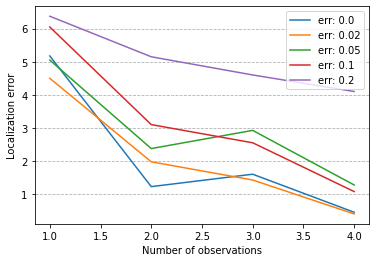

In [ ]:
import matplotlib.pyplot as plt

E = [0.0, 0.02, 0.05, 0.1, 0.2]
legend_plot = list()
for i in range(5):
    plot_label, = plt.plot([j+1 for j in range(4)], localization_error[i], label = "err: "+str(E[i]))
    legend_plot.append(plot_label)
plt.legend(handles = legend_plot)
plt.grid(axis='y', linestyle='--')
plt.ylabel("Localization error")
plt.xlabel("Number of observations")
plt.show()

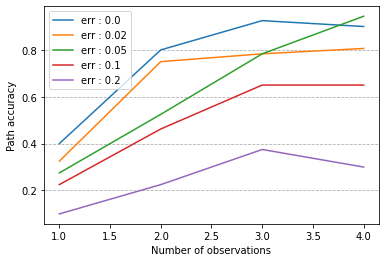

In [ ]:
import matplotlib.pyplot as plt

E = [0.0, 0.02, 0.05, 0.1, 0.2]
legend_plot = list()
for i in range(5):
    plot_label, = plt.plot([j+1 for j in range(4)], path_accuracy[i], label = "err : "+str(E[i]))
    legend_plot.append(plot_label)
plt.legend(handles = legend_plot)
plt.grid(axis='y', linestyle='--')
plt.ylabel("Path accuracy")
plt.xlabel("Number of observations")
plt.show()